<h3 align="center">Movie Rating Prediction using Collaborative Filtering</h3> 

<h3>Stage: 1</h3> 

#### Dependencies for the project

In [1]:
import pandas as pd
import numpy as np
import operator
from math import sqrt
import timeit

####    Reading the dataset and assigning column names.

In [2]:
columns = ['user','movie','rating','idk']
data = pd.read_csv("ratings_training_80.csv",names = columns)
test = pd.read_csv("ratings_test_20.csv",names = columns)

#### Removing the extra feature/column

In [3]:
data = data.drop('idk', 1)
test = test.drop('idk', 1)

### Scaling Data
    * Scaling data for pearson corelation or centered cosine

In [4]:
#
# Getting average rating for a user
#
all_user = list(set(data.user))
avg_rating_of_user = []
for i in range(len(all_user)):
    df = data.ix[data.user==i]
    avg_rating_of_user.append([i,np.average(df.rating.values)])

In [5]:
all_users= data.user.unique()
avg_rating = []
for i in all_users:
    avg_rating.append([i,np.average(data[data.user==i].rating.values)])
data['scaled'] = 0
for i in all_users:
    data['scaled'][data.user == i] = avg_rating[i][1]

data['adj_rating'] = data.rating - data.scaled

# creates pivoted dataframe
data_ibs = data.pivot(index='user', columns='movie', values='adj_rating')
data_ibs = data_ibs.fillna(0)

/Users/ishansingh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [151]:
# this similarity should be between -1 to 1
def my_cosine(vec1,vec2):
    num = 0
    den1 = 0
    den2 = 0
    for i in range(len(vec1)):
        num += vec1[i]*vec2[i]
        if(vec1[i]==0 or vec2[i]==0):
            continue
        else:
            den1 += vec1[i]**2
            den2 += vec2[i]**2
    den = sqrt(den1) * sqrt(den2)
    sim = num/den
    return sim

# Only uncomment when you want to create one.

#sim_mat = pd.DataFrame(np.zeros((9216, 9216)))
#sim_mat = sim_mat.replace(0,-5)

# Sim function is the main Guy

In [78]:
def sim(test_instance,data,pivot_df):
    similarity = []
    item_for_test = int(test_instance.movie.values)
    for_user = int(test_instance.user.values)
    checkonly_movies = data.ix[data.user==for_user].movie.values  # normal df is used here
    for m in checkonly_movies:
        # using pivot data
        if sim_mat[item_for_test][m] == -5:
            sim = my_cosine(pivot_df[item_for_test], pivot_df[m])
            sim_mat[item_for_test][m] = sim
            sim_mat[m][item_for_test] = sim
            rating = pivot_df[m][for_user]
            similarity.append((m,sim,for_user,item_for_test,rating))
        else:
            sim = sim_mat[item_for_test][m]
            rating = pivot_df[m][for_user]
            similarity.append((m,sim,for_user,item_for_test,rating))
    #similarity.sort(key=operator.itemgetter(1))
    return similarity

In [79]:
from datetime import datetime
prediction = []
count = 0
start = timeit.default_timer()
for i in range(len(test)):
    count += 1
    simi = sim(test.loc[i:i,],data,data_ibs)
    sim1 = 0
    semi_sim = 0
    for i in simi:
        from_movie = int(i[0])
        similar = i[1]
        user = int(i[2])
        pred_movie = i[3]
        if(similar > 0):
            tmp = data[(data.movie==from_movie) & (data.user == user)].rating.values*similar
            semi_sim += tmp[0]
            sim1 += similar
            temprate = test[(test.movie==pred_movie) & (test.user == user)].rating.values
    prediction.append([user,pred_movie,temprate,semi_sim,sim1])
    if(count%100 == 0):
        print('Step:',count, 'time:',str(datetime.now().time()))
stop = timeit.default_timer()
print('total time:',stop - start) #8.402558507048525

Step: 100 time: 17:31:13.286579
Step: 200 time: 17:31:30.355924
Step: 300 time: 17:33:08.637983
Step: 400 time: 17:34:31.178151
Step: 500 time: 17:35:40.481126
Step: 600 time: 17:36:04.085207
Step: 700 time: 17:36:27.354298
Step: 800 time: 17:37:01.610103
Step: 900 time: 17:37:43.456538
Step: 1000 time: 17:38:14.015593
Step: 1100 time: 17:39:12.766593
Step: 1200 time: 17:39:32.316541
Step: 1300 time: 17:39:40.541860
Step: 1400 time: 17:39:47.649188
Step: 1500 time: 17:40:10.242779
Step: 1600 time: 17:40:29.632386
Step: 1700 time: 17:40:51.563710
Step: 1800 time: 17:40:59.593489
Step: 1900 time: 17:41:09.617277
Step: 2000 time: 17:42:22.118789
Step: 2100 time: 17:43:39.418782
Step: 2200 time: 17:44:27.427226
Step: 2300 time: 17:44:46.708430
Step: 2400 time: 17:44:58.583354
Step: 2500 time: 17:45:09.388883
Step: 2600 time: 17:45:47.120595
Step: 2700 time: 17:47:19.923668
Step: 2800 time: 17:51:06.232841
Step: 2900 time: 17:55:49.962789
Step: 3000 time: 18:08:28.794667
Step: 3100 time: 18

In [153]:
# save it for future use.
#sim_mat.to_csv('similaritymatrix.csv')

col = ['user','movie','rating','sim_num','sim_den']
df= pd.DataFrame(prediction, columns=col)
df['prediction'] = round(df.sim_num/df.sim_den,1)
actual_rating = []
for i in range(len(df.rating)):
    actual_rating.append(df.rating[i][0])
df = df.drop('rating', 1)
df = df.drop('sim_num', 1)
df = df.drop('sim_den', 1)
df['rating'] = actual_rating

df = df[['user','movie','rating','prediction']]
df.to_csv('ratings_predictions_20_cf.csv')

In [144]:
mse1_20 = (((df.prediction - df.rating) ** 2).sum()) / len(df.prediction)
pow(mse1_20,0.5)  # 0.9083914275558426

0.9083914275558426

### Conducted the metric work below, manually copy pasted the values after various runs.

In [25]:
RMSE_CF = [0.9083914275558426, 0.9147539035726028, 0.9006375913247227, 0.8986882417760402]
splitType = ['CF_80-20', 'CF_85-15', 'CF_90-10', 'CF_95-05']
time_CF = [64515.90813413006,62773.40323617036,
        58426.296713575,51463.84230065497]
cf_metric = pd.DataFrame(splitType,columns=['CF-Type'])
cf_metric['RMSE_CF'] = RMSE_CF
cf_metric['time_CF'] = time_CF

# below is hard coded for all metric of the project
time = [660.6614640900079, 662.0650260520051, 
        660.425073802995,700.3680259380053, 
        668.4838295660011, 653.8688204270002,
       64515.90813413006,62773.40323617036,
        58426.296713575,51463.84230065497]
algorithm = ['Wt-KNN', 'Wt-KNN', 'Wt-KNN', 'UNWT-KNN', 'UNWT-KNN', 'UNWT-KNN','CF_80-20', 'CF_85-15', 'CF_90-10', 'CF_95-05']
rmse = [1.2707091613268062, 1.1444297704440511, 
        1.054834443814851,1.127934707729547, 
        1.0604713965491257, 1.02051020791709,
       0.9083914275558426, 0.9147539035726028, 
        0.9006375913247227, 0.8986882417760402]

k = [3,5,10,3,5,10,'NA','NA','NA','NA']
metric = pd.DataFrame(algorithm,columns=['Algorithm'])
metric['K'] = k
metric['time'] = time
metric['rmse'] = rmse

In [26]:
print(metric)

  Algorithm   K          time      rmse
0    Wt-KNN   3    660.661464  1.270709
1    Wt-KNN   5    662.065026  1.144430
2    Wt-KNN  10    660.425074  1.054834
3  UNWT-KNN   3    700.368026  1.127935
4  UNWT-KNN   5    668.483830  1.060471
5  UNWT-KNN  10    653.868820  1.020510
6  CF_80-20  NA  64515.908134  0.908391
7  CF_85-15  NA  62773.403236  0.914754
8  CF_90-10  NA  58426.296714  0.900638
9  CF_95-05  NA  51463.842301  0.898688


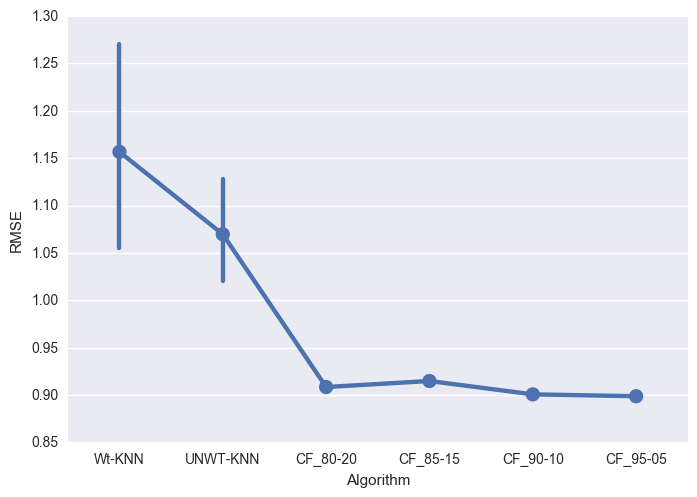

In [24]:
g = sns.pointplot(x="Algorithm", y="rmse", data=metric)
g.set(xlabel='Algorithm', ylabel='RMSE')
plt.show()

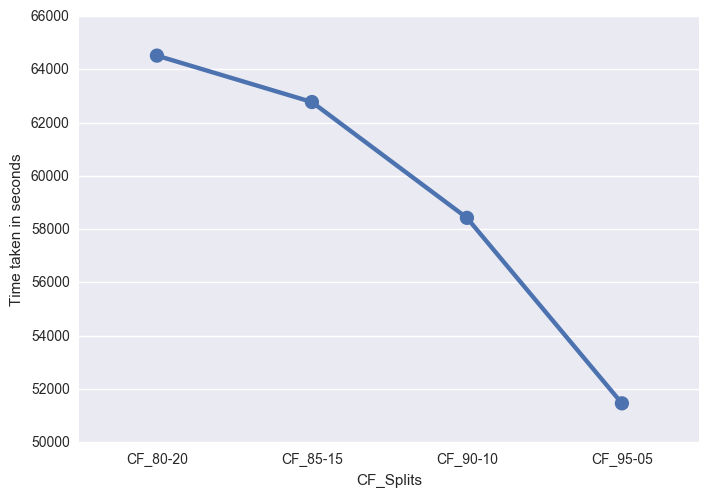

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.pointplot(x="CF-Type", y="time_CF", data=cf_metric)
g.set(xlabel='CF_Splits', ylabel='Time taken in seconds')
plt.show()

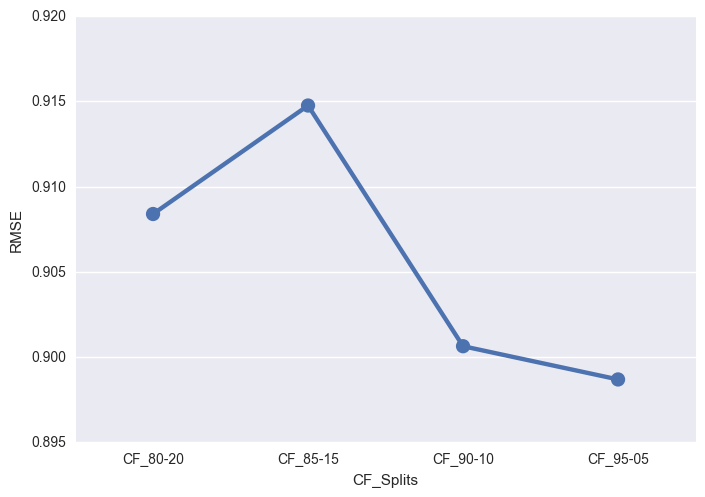

In [22]:
g = sns.pointplot(x="CF-Type", y="RMSE_CF", data=cf_metric)
g.set(xlabel='CF_Splits', ylabel='RMSE')
plt.show()